# Google analytics customer revenue prediction 
The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

GStore

RStudio, the developer of free and open tools for R and enterprise-ready products for teams to scale and share work, has partnered with Google Cloud and Kaggle to demonstrate the business impact that thorough data analysis can have.

In this competition, you’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.


More details can be found here https://www.kaggle.com/c/ga-customer-revenue-prediction/data

## Getting Raw data and basic statistics

In [1]:
#Import library and package
import os
import pandas as pd
#os.chdir("C:\\Users\\suman\\Desktop\\datasciencenew\\appliedai\\customerrevenueprediction")
os.chdir("C:\\Users\\suman\\Downloads\\googlerevenue")

In [45]:
import warnings
warnings.filterwarnings('ignore')
raw_data_train=pd.read_csv("train.csv")

In [3]:
print(raw_data_train.describe(include='all'))
raw_data_train.info()

       channelGrouping          date  \
count           903653  9.036530e+05   
unique               8           NaN   
top     Organic Search           NaN   
freq            381561           NaN   
mean               NaN  2.016589e+07   
std                NaN  4.697698e+03   
min                NaN  2.016080e+07   
25%                NaN  2.016103e+07   
50%                NaN  2.017011e+07   
75%                NaN  2.017042e+07   
max                NaN  2.017080e+07   

                                                   device  fullVisitorId  \
count                                              903653   9.036530e+05   
unique                                                176   7.427350e+05   
top     {"browser": "Chrome", "browserVersion": "not a...   1.957459e+18   
freq                                               284522   2.050000e+02   
mean                                                  NaN            NaN   
std                                                   NaN      

So the dataset has .9 mil row 12 columns 4 are of int64 type and 8 are of object type

In [4]:
#raw_data_train.fullVisitorId.unique  #903653 count so no duplicate value

## preprocessing raw data

There are 4 json type data we will flatten those
sum up all transaction per users

In [46]:
processing_data_train=raw_data_train

In [47]:
print(id(processing_data_train)) 
print(id(raw_data_train))

2283409695128
2283409695128


In [48]:
raw_data_train.columns

Index(['channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
       'sessionId', 'socialEngagementType', 'totals', 'trafficSource',
       'visitId', 'visitNumber', 'visitStartTime'],
      dtype='object')

#### Flatten json data as new columns

In [49]:
#Convert JSON data to new columns device geoNetwork totals trafficSource should be flattened

aa=pd.DataFrame(processing_data_train.pop('device').apply(pd.io.json.loads).values.tolist(), index=processing_data_train.index)
processing_data_train=processing_data_train.join(aa)

aa=pd.DataFrame(processing_data_train.pop('trafficSource').apply(pd.io.json.loads).values.tolist(), index=processing_data_train.index)
processing_data_train=processing_data_train.join(aa)

aa=pd.DataFrame(processing_data_train.pop('geoNetwork').apply(pd.io.json.loads).values.tolist(), index=processing_data_train.index)
processing_data_train=processing_data_train.join(aa)

aa=pd.DataFrame(processing_data_train.pop('totals').apply(pd.io.json.loads).values.tolist(), index=processing_data_train.index)
processing_data_train=processing_data_train.join(aa)

In [50]:
#processing_data_train.info()

After flattening 4 json new dimension 1 bool 4 int 45 object

Now we will remove the rows where predicted variable doesnot have any value. Check again

Also we will flatten another json created from above

In [51]:
processing_data_train = processing_data_train[pd.notnull(processing_data_train['transactionRevenue'])]
aa=processing_data_train['adwordsClickInfo'].apply(lambda x: pd.Series(x))
processing_data_train=processing_data_train.join(aa)

In [52]:
processing_data_train=processing_data_train.drop('adwordsClickInfo',axis=1)
processing_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11515 entries, 752 to 903317
Data columns (total 56 columns):
channelGrouping              11515 non-null object
date                         11515 non-null int64
fullVisitorId                11515 non-null object
sessionId                    11515 non-null object
socialEngagementType         11515 non-null object
visitId                      11515 non-null int64
visitNumber                  11515 non-null int64
visitStartTime               11515 non-null int64
browser                      11515 non-null object
browserSize                  11515 non-null object
browserVersion               11515 non-null object
deviceCategory               11515 non-null object
flashVersion                 11515 non-null object
isMobile                     11515 non-null bool
language                     11515 non-null object
mobileDeviceBranding         11515 non-null object
mobileDeviceInfo             11515 non-null object
mobileDeviceMarketingName  

Now data set has 1 bool,4 int,52 obj and 11k rows
we will exclude some columns adContent campaignCode bounces   adNetworkType  gclId  isVideoAd page  slot targetingCriteria because those are having more than 90% NA value

#### Drop columns with 90% null value

In [53]:
all_columns=raw_data_train.columns
print('total no of columns',len(all_columns))
processing_data_train=processing_data_train.drop(['adContent','campaignCode','bounces','adNetworkType','gclId','isVideoAd','page','slot','targetingCriteria'],axis=1)
clean_columns=processing_data_train.columns

total no of columns 11


In [54]:
print('after removing columns where 90% null value no of columns',len(clean_columns))
#processing_data_train.info()

after removing columns where 90% null value no of columns 47


Now there are some columns with null value maybe we should impute value there for newVisits  referralPath  keyword isTrueDirect

In [55]:
processing_data_train['newVisits'].value_counts()  # only single value
processing_data_train['keyword'].value_counts() #most values are not provided 3387 out of 3500 so can be removed
processing_data_train['isTrueDirect'].value_counts() #all are true so can be removed
processing_data_train['referralPath'].value_counts() #most values are from /mail/u/ 5151 of 5300 so can be removed
processing_data_train=processing_data_train.drop(['newVisits','referralPath','keyword','isTrueDirect'],axis=1)
clean_columns=processing_data_train.columns
print('after removing the most same values no of columns',len(clean_columns))

after removing the most same values no of columns 43


In [56]:
processing_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11515 entries, 752 to 903317
Data columns (total 43 columns):
channelGrouping              11515 non-null object
date                         11515 non-null int64
fullVisitorId                11515 non-null object
sessionId                    11515 non-null object
socialEngagementType         11515 non-null object
visitId                      11515 non-null int64
visitNumber                  11515 non-null int64
visitStartTime               11515 non-null int64
browser                      11515 non-null object
browserSize                  11515 non-null object
browserVersion               11515 non-null object
deviceCategory               11515 non-null object
flashVersion                 11515 non-null object
isMobile                     11515 non-null bool
language                     11515 non-null object
mobileDeviceBranding         11515 non-null object
mobileDeviceInfo             11515 non-null object
mobileDeviceMarketingName  

Here we dont have any column with null value

In [57]:
processing_data_train.iloc[:,29:40]

,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,hits,pageviews
752,Americas,United States,not available in demo dataset,not available in demo dataset,Detroit MI,(not set),not available in demo dataset,Michigan,Northern America,11,11
753,Americas,United States,not available in demo dataset,not available in demo dataset,New York NY,(not set),not available in demo dataset,New York,Northern America,11,10
799,Americas,United States,not available in demo dataset,not available in demo dataset,New York NY,(not set),not available in demo dataset,New York,Northern America,13,11
802,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,13,12
859,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Northern America,17,14
866,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,17,17
893,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,comcast.net,not available in demo dataset,California,Northern America,19,16
910,Americas,United States,not available in demo dataset,not available in demo dataset,Seattle-Tacoma WA,(not set),not available in demo dataset,Washington,Northern America,20,15
922,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,directmusicservice.com,not available in demo dataset,California,Northern America,22,16
925,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,22,20


Check for distribution of values in each columns and remove with close to 0 variance

In [58]:
for i in clean_columns:
    print("for columns : ",i)
    print("distribution of data as below")
    print(processing_data_train[i].value_counts())
    print("*"*50)

for columns :  channelGrouping
distribution of data as below
Referral          5311
Organic Search    3438
Direct            2042
Paid Search        468
Display            142
Social             104
Affiliates           9
(Other)              1
Name: channelGrouping, dtype: int64
**************************************************
for columns :  date
distribution of data as below
20161216    87
20161212    83
20170501    78
20161213    77
20161205    76
20161128    73
20161209    72
20161215    72
20160812    71
20170503    70
20161206    70
20161219    69
20170217    67
20161220    67
20170502    67
20161208    66
20160815    65
20161214    65
20160825    62
20170713    62
20170612    61
20170731    61
20160816    59
20170428    59
20160823    57
20160822    57
20161130    57
20170719    56
20170512    54
20170214    51
            ..
20170205    12
20170225    12
20161008    12
20170101    11
20170507    11
20170108    11
20170114    11
20161029    11
20170121    11
20170312    11
201

not available in demo dataset    11515
Name: operatingSystemVersion, dtype: int64
**************************************************
for columns :  screenColors
distribution of data as below
not available in demo dataset    11515
Name: screenColors, dtype: int64
**************************************************
for columns :  screenResolution
distribution of data as below
not available in demo dataset    11515
Name: screenResolution, dtype: int64
**************************************************
for columns :  campaign
distribution of data as below
(not set)                                          11050
AW - Dynamic Search Ads Whole Site                   323
AW - Accessories                                     130
Data Share Promo                                       9
Retail (DO NOT EDIT owners nophakun and tianyu)        1
AW - Apparel                                           1
test-liyuhz                                            1
Name: campaign, dtype: int64
***************

Name: criteriaParameters, dtype: int64
**************************************************


#### remove 0 variance features
fullVisitorId sessionId visitId  doesnot requir for prediction
socialEngagementType browserSize browserVersion flashVersion language mobileDeviceBranding mobileDeviceInfo mobileDeviceMarketingName
 mobileDeviceModel mobileInputSelector operatingSystemVersion screenColors screenResolution cityId latitude networkLocation visits
 criteriaParameters 0 variance

So we will ignore those columns

In [59]:
processing_data_train=processing_data_train.drop(['fullVisitorId','sessionId','visitId','socialEngagementType','browserSize','browserVersion','flashVersion','language','mobileDeviceBranding','mobileDeviceInfo','mobileDeviceMarketingName','mobileDeviceModel','mobileInputSelector','operatingSystemVersion','screenColors','screenResolution','cityId','latitude','networkLocation','visits','criteriaParameters'],axis=1)
clean_columns=processing_data_train.columns
print('after these clean no of columns',len(clean_columns))

after these clean no of columns 22


In [60]:
processing_data_train.sample()

,channelGrouping,date,visitNumber,visitStartTime,browser,deviceCategory,isMobile,operatingSystem,campaign,medium,...,continent,country,longitude,metro,networkDomain,region,subContinent,hits,pageviews,transactionRevenue
518499,Organic Search,20170528,1,1496020392,Chrome,mobile,True,Android,(not set),organic,...,Americas,United States,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,Northern America,38,32,16990000


In [61]:
for i in clean_columns:
    print("for columns : ",i)
    print("distribution of data as below")
    print(processing_data_train[i].value_counts())
    print("*"*50)

for columns :  channelGrouping
distribution of data as below
Referral          5311
Organic Search    3438
Direct            2042
Paid Search        468
Display            142
Social             104
Affiliates           9
(Other)              1
Name: channelGrouping, dtype: int64
**************************************************
for columns :  date
distribution of data as below
20161216    87
20161212    83
20170501    78
20161213    77
20161205    76
20161128    73
20161209    72
20161215    72
20160812    71
20170503    70
20161206    70
20161219    69
20170217    67
20161220    67
20170502    67
20161208    66
20160815    65
20161214    65
20160825    62
20170713    62
20170612    61
20170731    61
20160816    59
20170428    59
20160823    57
20160822    57
20161130    57
20170719    56
20170512    54
20170214    51
            ..
20170205    12
20170225    12
20161008    12
20170101    11
20170507    11
20170108    11
20170114    11
20161029    11
20170121    11
20170312    11
201

18     375
16     362
15     354
14     348
17     348
19     345
20     329
21     313
13     313
23     311
24     292
22     290
26     279
25     269
28     267
27     263
30     261
12     258
29     222
31     207
32     204
34     198
11     193
33     193
35     193
37     177
36     175
38     172
40     159
43     155
      ... 
174      1
192      1
308      1
237      1
157      1
243      1
471      1
238      1
278      1
347      1
386      1
209      1
328      1
385      1
195      1
382      1
182      1
279      1
135      1
161      1
194      1
165      1
189      1
246      1
311      1
361      1
152      1
387      1
133      1
158      1
Name: hits, Length: 215, dtype: int64
**************************************************
for columns :  pageviews
distribution of data as below
16     478
15     471
14     467
13     453
18     451
17     445
21     407
20     397
12     385
11     374
19     367
22     367
24     347
23     334
26     331
25     297
27     26

remove campaign longitude as variance 0

In [62]:
processing_data_train=processing_data_train.drop(['campaign','longitude'],axis=1)
clean_columns=processing_data_train.columns

## Featurization part 1
convert date to dayofweek and visitStartTime to morning,afternoon,evening,night

In [63]:
def changetime(time1):  
    a='NA' 
    if (time1>500000000 and time1<=1000000000):
        a='Morning'
    elif (time1>1000000000 and time1<=1600000000):
        a='Afternoon'
    elif (time1>1600000000 and time1<=2000000000):
        a='Evening'
    elif (time1>2000000000 and time1<=2400000000):
        a='Night'
    elif (time1>0 and time1<=500000000):
        a='Mid Night'
    return a 


In [64]:
print(processing_data_train['visitStartTime'][1:3])
processing_data_train['visitStartTime']=processing_data_train['visitStartTime'].apply(changetime)
print(processing_data_train['visitStartTime'][1:3])

753    1472844906
799    1472827393
Name: visitStartTime, dtype: int64
753    Afternoon
799    Afternoon
Name: visitStartTime, dtype: object


In [65]:
import datetime,calendar
print(processing_data_train['date'][0:2])
processing_data_train['date']=  \
  processing_data_train['date'].apply(lambda x: calendar.day_name[datetime.date(int(str(x)[:4]),int(str(x)[4:6]),int(str(x)[6:8])).weekday()])
processing_data_train['date'][0:2]

752    20160902
753    20160902
Name: date, dtype: int64


752    Friday
753    Friday
Name: date, dtype: object

#### Text feature creation

In [66]:
#source and networkDomain contains website names so we need merge and to find text feature from it with minimum count of words 10
from sklearn.feature_extraction.text import CountVectorizer
import re
def txt(text):
    text=str(text).replace("."," ")
    text=str(text).replace("(","")
    text=str(text).replace(")","")
    text=str(text).replace("com","")
    return text    
 
#merging source text and networkDomain text into source column    
processing_data_train['source']= processing_data_train["source"].map(str) + processing_data_train["networkDomain"]
    
count_vect = CountVectorizer( lowercase=True,min_df =10) #in scikit-learn
final_counts = count_vect.fit_transform(processing_data_train['source'].values)
#b = count_vect.fit_transform(processing_data_train['source'].values)

print('text shape',final_counts.get_shape(),type(final_counts))
print('df shape',processing_data_train.shape)
#merge 
processing_data_train=processing_data_train.drop(['source','networkDomain'],axis=1)
print(processing_data_train[0:3])
processing_data_train=processing_data_train.reset_index()
print(processing_data_train[0:3])
print(pd.DataFrame(final_counts.todense())[0:3])
print(pd.DataFrame(final_counts.todense()).reset_index()[0:3])
#processing_data_train=pd.DataFrame(final_counts.todense()).reset_index().join(processing_data_train)
processing_data_train.sample()
processing_data_train=pd.DataFrame(final_counts.todense()).join(processing_data_train)
processing_data_train.info()

text shape (11515, 82) <class 'scipy.sparse.csr.csr_matrix'>
df shape (11515, 20)
    channelGrouping    date  visitNumber visitStartTime browser  \
752          Direct  Friday            1      Afternoon  Chrome   
753  Organic Search  Friday            3      Afternoon  Chrome   
799        Referral  Friday            7      Afternoon  Chrome   

    deviceCategory  isMobile operatingSystem    medium       city continent  \
752        desktop     False           Linux    (none)  Ann Arbor  Americas   
753        desktop     False       Macintosh   organic   New York  Americas   
799        desktop     False           Linux  referral   New York  Americas   

           country        metro    region      subContinent hits pageviews  \
752  United States   Detroit MI  Michigan  Northern America   11        11   
753  United States  New York NY  New York  Northern America   11        10   
799  United States  New York NY  New York  Northern America   13        11   

    transactionReve

First convert the types
also create log of transactionRevenue
#### Take log of revenue

In [67]:
import numpy as np
print(processing_data_train['transactionRevenue'][0:2])
processing_data_train['logtransactionRevenue']=processing_data_train['transactionRevenue'].apply(lambda x: np.log(int(x)+1))
print(processing_data_train['logtransactionRevenue'][0:2])

0     37860000
1    306670000
Name: transactionRevenue, dtype: object
0    17.449406
1    19.541283
Name: logtransactionRevenue, dtype: float64


## Visualize the data



In [27]:
print(processing_data_train['logtransactionRevenue'][0:2])

0    17.449406
1    19.541283
Name: logtransactionRevenue, dtype: float64


In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(processing_data_train['logtransactionRevenue'])
plt.ylabel("frequency")
plt.title("Log of transaction revenue probability density function")
plt.show()

<Figure size 640x480 with 1 Axes>

In [29]:
# Lets look at the words and the corresponding columns so we need a dict for plotting
print(count_vect.vocabulary_)
dictvocabulary=count_vect.vocabulary_
def findkey(x):
    a="notfound"
    for key, value in dictvocabulary.items(): 
      if (value == x):
        a=key
    return a    

{'googlewayport': 56, 'att': 0, 'googletwtelecom': 53, 'googlemchsi': 42, 'bhn': 1, 'googlefrontiernet': 40, 'set': 73, 'googlecom': 36, 'facebook': 28, 'ca': 2, 'mail': 60, 'googlecomcast': 37, 'direct': 26, 'edu': 27, 'googlecantv': 34, 'commanaged': 12, 'rr': 71, 'qwest': 69, 'googleunknown': 54, 'comcastbusiness': 7, 'co': 3, 'comrcn': 15, 'comztomy': 21, 'googlespcsdns': 51, 'googleqwest': 46, 'googleatt': 31, 'dfacomcastbusiness': 25, 'mx': 62, 'gdeals': 29, 'pass': 68, 'googlesbcglobal': 50, 'yahoo': 79, 'comcom': 8, 'verizon': 77, 'dfa': 24, 'comcomcast': 9, 'groups': 59, 'googlefuse': 41, 'comverizon': 20, 'sites': 74, 'comcox': 11, 'googlecomcastbusiness': 38, 'otrs': 67, 'googleztomy': 58, 'googlewindstream': 57, 'youtube': 80, 'comoptonline': 13, 'mall': 61, 'googleplex': 45, 'wayport': 78, 'rcn': 70, 'optonline': 65, 'googlesuddenlink': 52, 'sbcglobal': 72, 'googleverizon': 55, 'googleoptonline': 44, 'com': 4, 'dealspotr': 23, 'comqwest': 14, 'googlecogentco': 35, 'googler

word : att  : is catagorigal
0    11505
1       10
Name: 0, dtype: int64


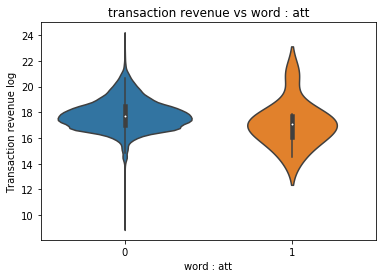

word : bhn  : is catagorigal
0    11505
1       10
Name: 1, dtype: int64


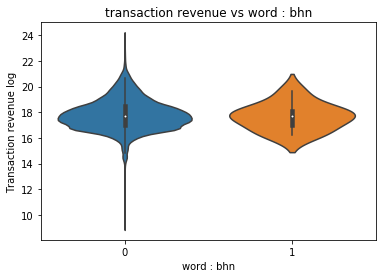

word : ca  : is catagorigal
0    11457
1       58
Name: 2, dtype: int64


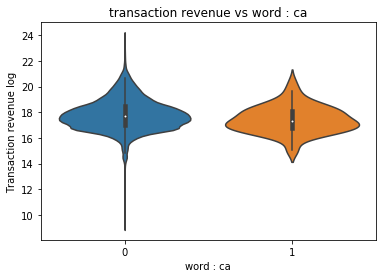

word : co  : is catagorigal
0    11493
1       22
Name: 3, dtype: int64


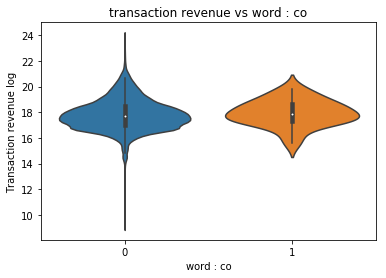

word : com  : is catagorigal
0    6533
1    4982
Name: 4, dtype: int64


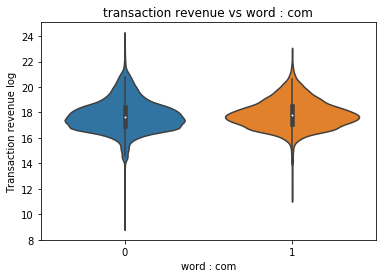

word : combhn  : is catagorigal
0    11503
1       12
Name: 5, dtype: int64


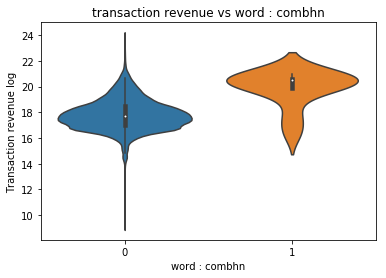

word : comcast  : is catagorigal
0    11373
1      142
Name: 6, dtype: int64


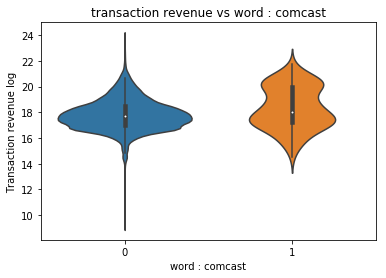

word : comcastbusiness  : is catagorigal
0    11376
1      139
Name: 7, dtype: int64


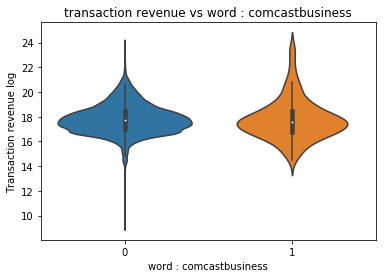

word : comcom  : is catagorigal
0    11499
1       16
Name: 8, dtype: int64


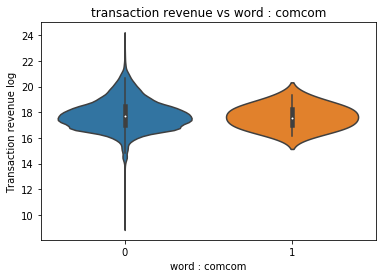

word : comcomcast  : is catagorigal
0    11061
1      454
Name: 9, dtype: int64


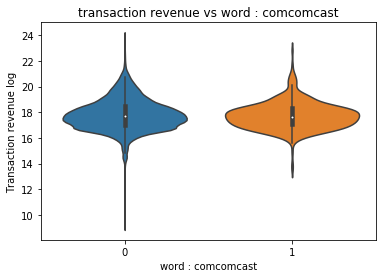

word : comcomcastbusiness  : is catagorigal
0    11461
1       54
Name: 10, dtype: int64


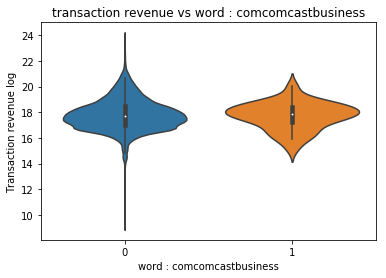

word : comcox  : is catagorigal
0    11481
1       34
Name: 11, dtype: int64


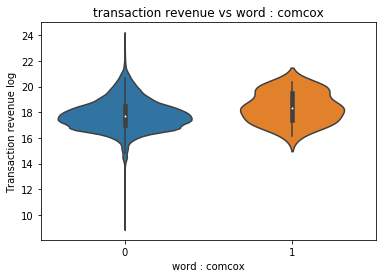

word : commanaged  : is catagorigal
0    11498
1       17
Name: 12, dtype: int64


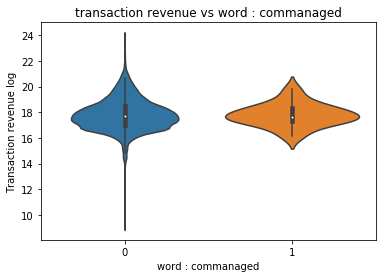

word : comoptonline  : is catagorigal
0    11468
1       47
Name: 13, dtype: int64


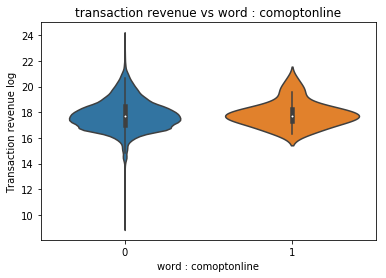

word : comqwest  : is catagorigal
0    11491
1       24
Name: 14, dtype: int64


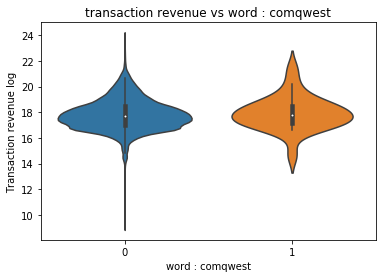

word : comrcn  : is catagorigal
0    11473
1       42
Name: 15, dtype: int64


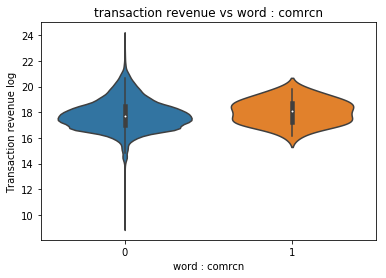

word : comrr  : is catagorigal
0    11411
1      104
Name: 16, dtype: int64


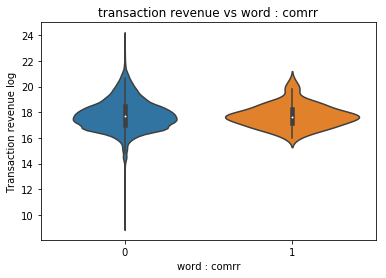

word : comsbcglobal  : is catagorigal
0    11473
1       42
Name: 17, dtype: int64


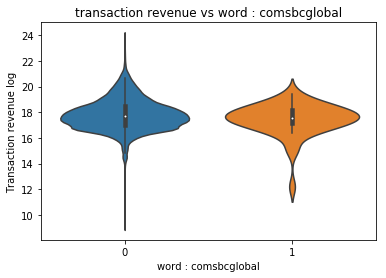

word : comtravelnet  : is catagorigal
0    11495
1       20
Name: 18, dtype: int64


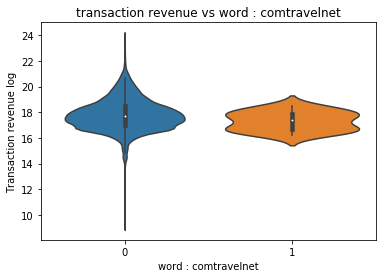

word : comunknown  : is catagorigal
0    11407
1      108
Name: 19, dtype: int64


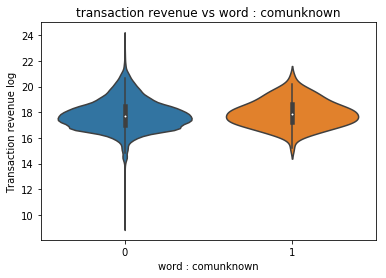

word : comverizon  : is catagorigal
0    11302
1      213
Name: 20, dtype: int64


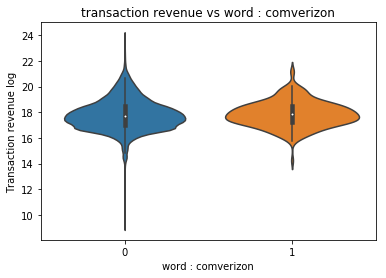

word : comztomy  : is catagorigal
0    11505
1       10
Name: 21, dtype: int64


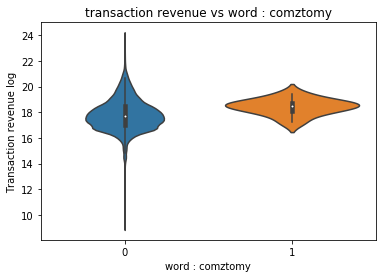

word : cox  : is catagorigal
0    11481
1       34
Name: 22, dtype: int64


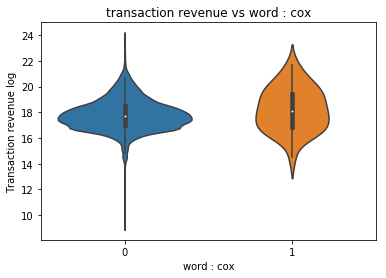

word : dealspotr  : is catagorigal
0    11475
1       40
Name: 23, dtype: int64


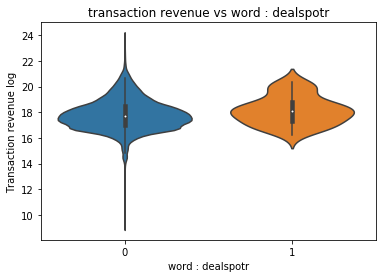

word : dfa  : is catagorigal
0    11426
1       89
Name: 24, dtype: int64


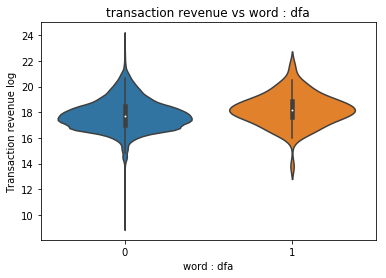

word : dfacomcastbusiness  : is catagorigal
0    11498
1       17
Name: 25, dtype: int64


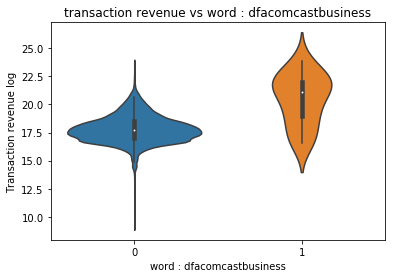

word : direct  : is catagorigal
0    9473
1    2042
Name: 26, dtype: int64


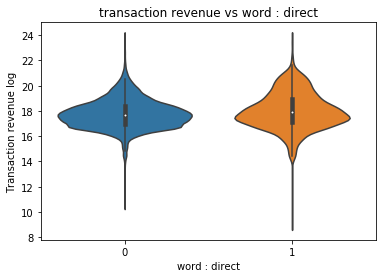

word : edu  : is catagorigal
0    11414
1      101
Name: 27, dtype: int64


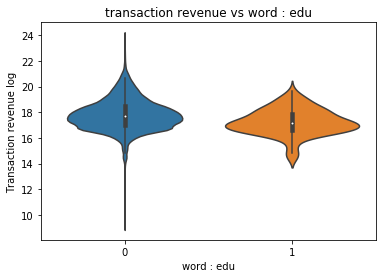

word : facebook  : is catagorigal
0    11476
1       39
Name: 28, dtype: int64


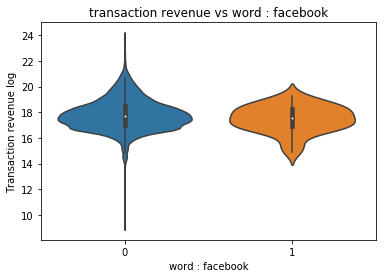

word : gdeals  : is catagorigal
0    11497
1       18
Name: 29, dtype: int64


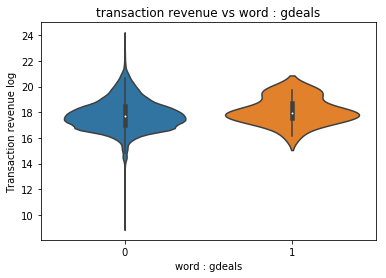

word : google  : is catagorigal
0    9812
1    1703
Name: 30, dtype: int64


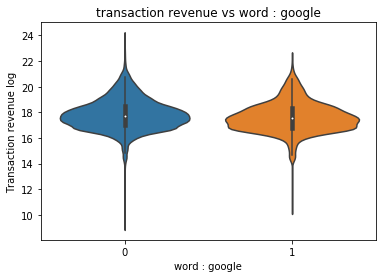

word : googleatt  : is catagorigal
0    11481
1       34
Name: 31, dtype: int64


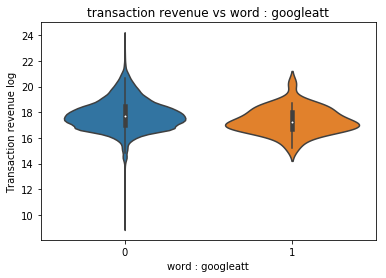

word : googlebell  : is catagorigal
0    11503
1       12
Name: 32, dtype: int64


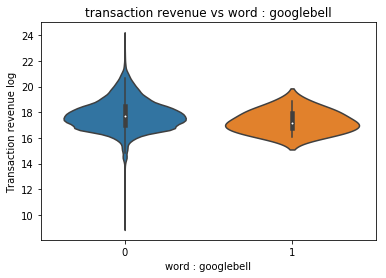

word : googlebhn  : is catagorigal
0    11475
1       40
Name: 33, dtype: int64


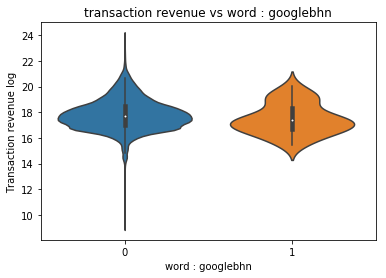

word : googlecantv  : is catagorigal
0    11475
1       40
Name: 34, dtype: int64


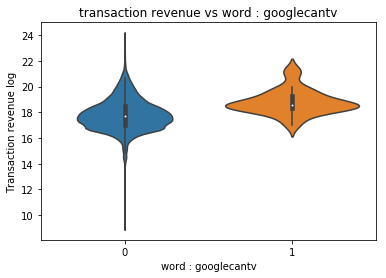

word : googlecogentco  : is catagorigal
0    11502
1       13
Name: 35, dtype: int64


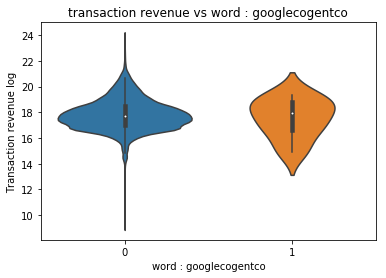

word : googlecom  : is catagorigal
0    11496
1       19
Name: 36, dtype: int64


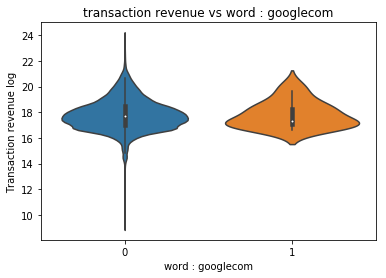

word : googlecomcast  : is catagorigal
0    11181
1      334
Name: 37, dtype: int64


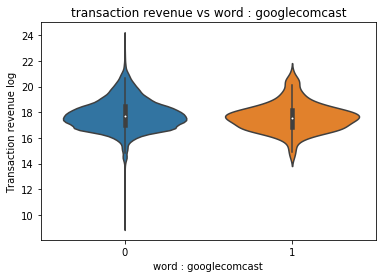

word : googlecomcastbusiness  : is catagorigal
0    11433
1       82
Name: 38, dtype: int64


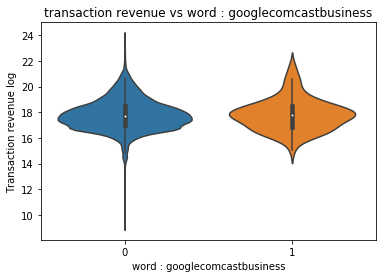

word : googlecox  : is catagorigal
0    11427
1       88
Name: 39, dtype: int64


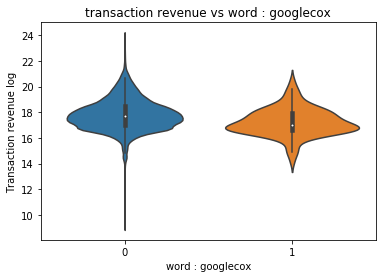

word : googlefrontiernet  : is catagorigal
0    11504
1       11
Name: 40, dtype: int64


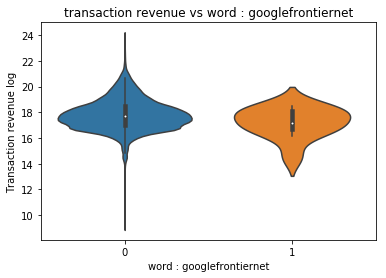

word : googlefuse  : is catagorigal
0    11505
1       10
Name: 41, dtype: int64


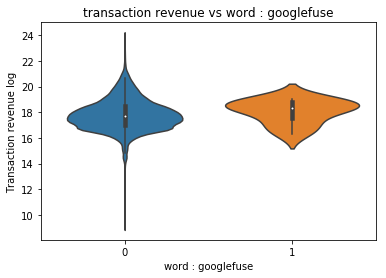

word : googlemchsi  : is catagorigal
0    11496
1       19
Name: 42, dtype: int64


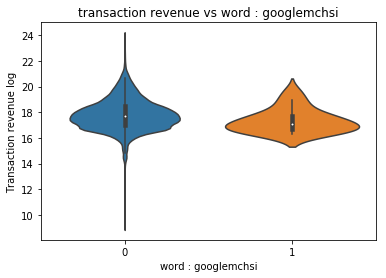

word : googlemycingular  : is catagorigal
0    11494
1       21
Name: 43, dtype: int64


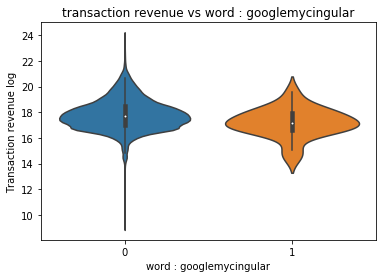

word : googleoptonline  : is catagorigal
0    11460
1       55
Name: 44, dtype: int64


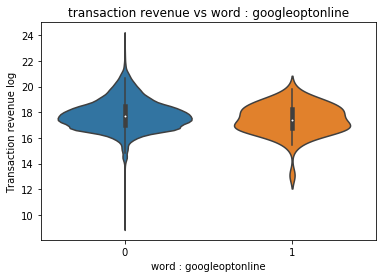

word : googleplex  : is catagorigal
0    6394
1    5121
Name: 45, dtype: int64


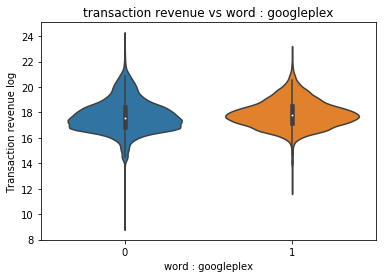

word : googleqwest  : is catagorigal
0    11467
1       48
Name: 46, dtype: int64


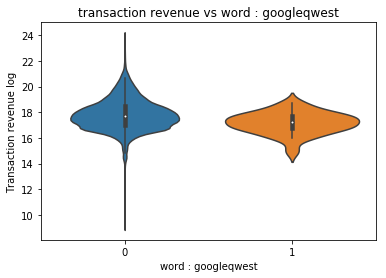

word : googlercn  : is catagorigal
0    11499
1       16
Name: 47, dtype: int64


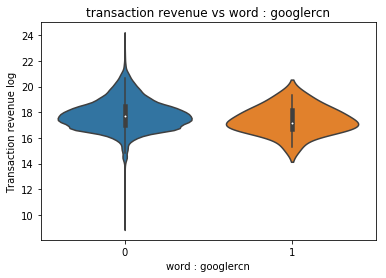

word : googlerogers  : is catagorigal
0    11503
1       12
Name: 48, dtype: int64


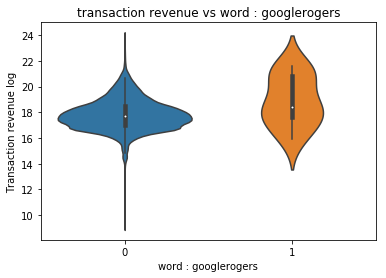

word : googlerr  : is catagorigal
0    11333
1      182
Name: 49, dtype: int64


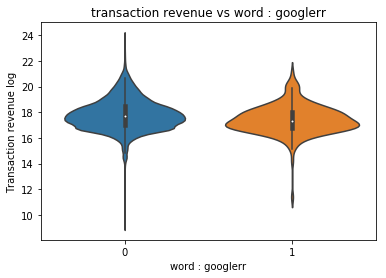

word : googlesbcglobal  : is catagorigal
0    11441
1       74
Name: 50, dtype: int64


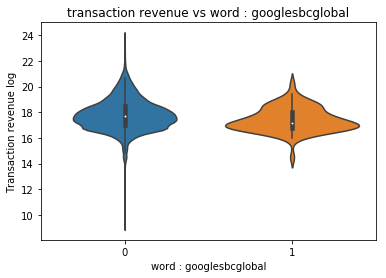

word : googlespcsdns  : is catagorigal
0    11504
1       11
Name: 51, dtype: int64


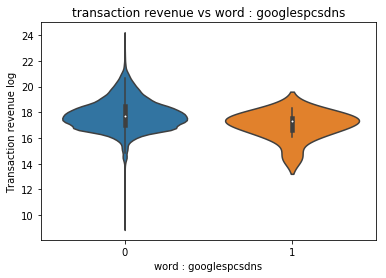

word : googlesuddenlink  : is catagorigal
0    11489
1       26
Name: 52, dtype: int64


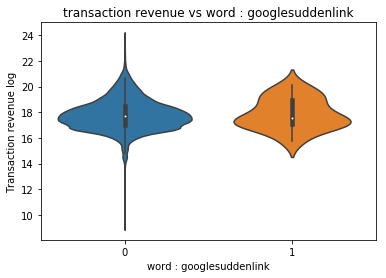

word : googletwtelecom  : is catagorigal
0    11502
1       13
Name: 53, dtype: int64


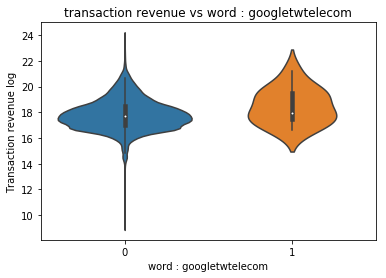

word : googleunknown  : is catagorigal
0    11290
1      225
Name: 54, dtype: int64


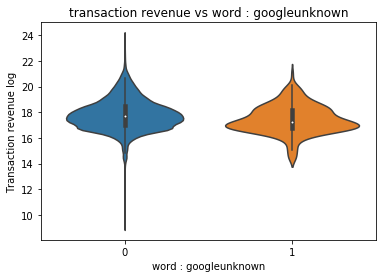

word : googleverizon  : is catagorigal
0    11351
1      164
Name: 55, dtype: int64


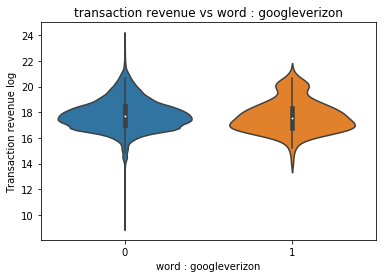

word : googlewayport  : is catagorigal
0    11502
1       13
Name: 56, dtype: int64


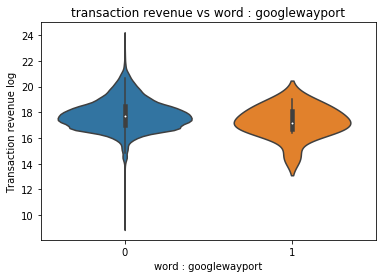

word : googlewindstream  : is catagorigal
0    11500
1       15
Name: 57, dtype: int64


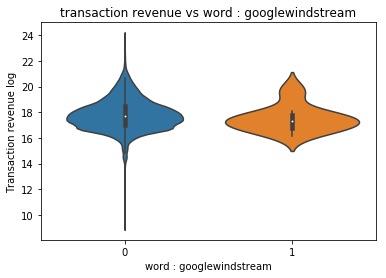

word : googleztomy  : is catagorigal
0    11488
1       27
Name: 58, dtype: int64


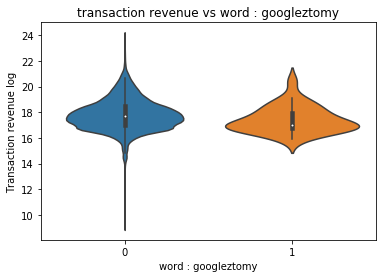

word : groups  : is catagorigal
0    11477
1       38
Name: 59, dtype: int64


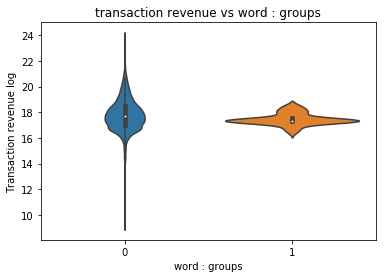

word : mail  : is catagorigal
0    11447
1       68
Name: 60, dtype: int64


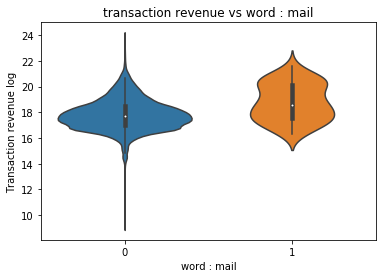

word : mall  : is catagorigal
0    6412
1    5103
Name: 61, dtype: int64


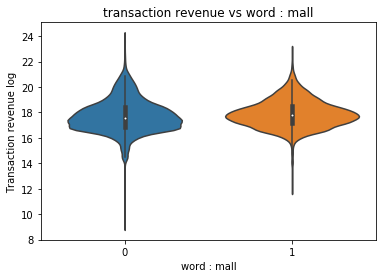

word : mx  : is catagorigal
0    11480
1       35
Name: 62, dtype: int64


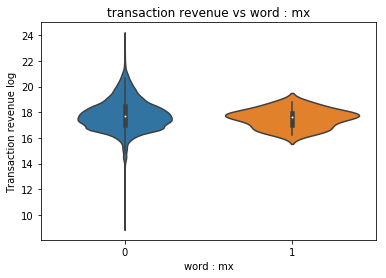

word : net  : is catagorigal
0    8454
1    3060
2       1
Name: 63, dtype: int64


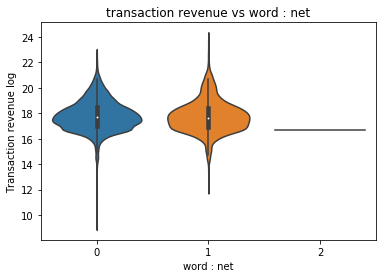

word : not  : is catagorigal
1    6645
0    4870
Name: 64, dtype: int64


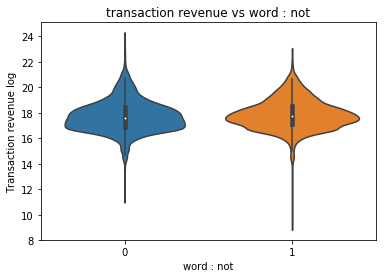

word : optonline  : is catagorigal
0    11486
1       29
Name: 65, dtype: int64


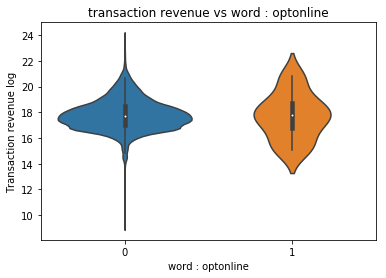

word : org  : is catagorigal
0    11470
1       45
Name: 66, dtype: int64


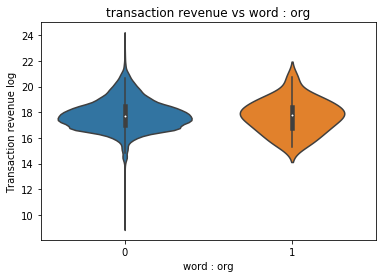

word : otrs  : is catagorigal
0    11486
1       29
Name: 67, dtype: int64


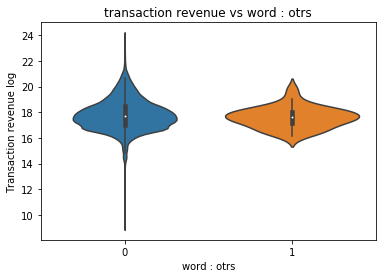

word : pass  : is catagorigal
0    11503
1       12
Name: 68, dtype: int64


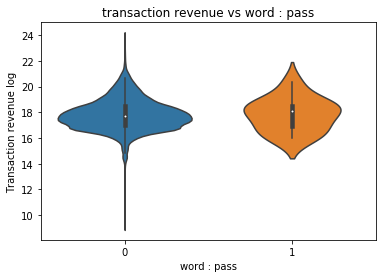

word : qwest  : is catagorigal
0    11498
1       17
Name: 69, dtype: int64


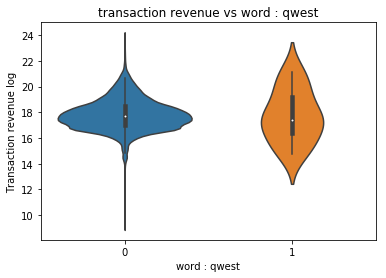

word : rcn  : is catagorigal
0    11504
1       11
Name: 70, dtype: int64


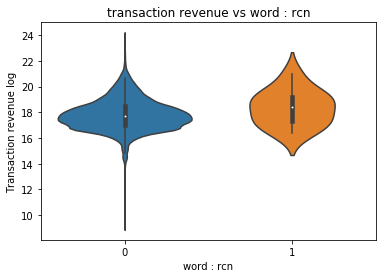

word : rr  : is catagorigal
0    11442
1       73
Name: 71, dtype: int64


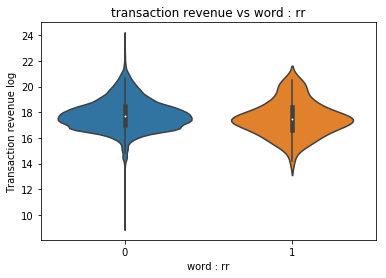

word : sbcglobal  : is catagorigal
0    11483
1       32
Name: 72, dtype: int64


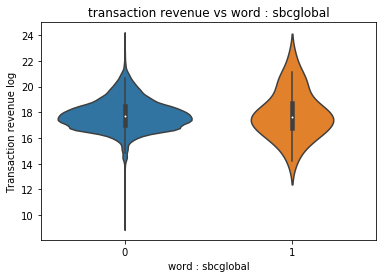

word : set  : is catagorigal
1    6645
0    4870
Name: 73, dtype: int64


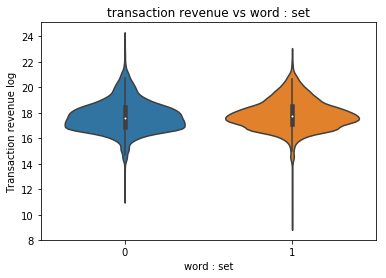

word : sites  : is catagorigal
0    11473
1       42
Name: 74, dtype: int64


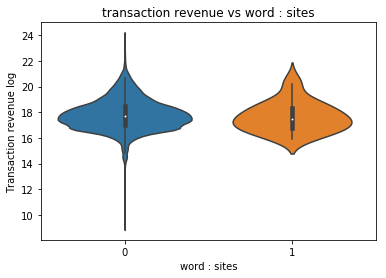

word : unknown  : is catagorigal
0    11115
1      339
2       61
Name: 75, dtype: int64


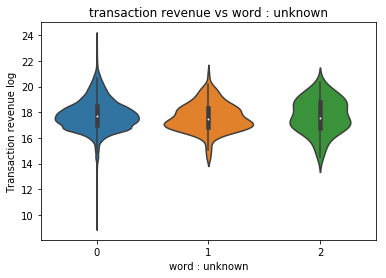

word : us  : is catagorigal
0    11503
1       12
Name: 76, dtype: int64


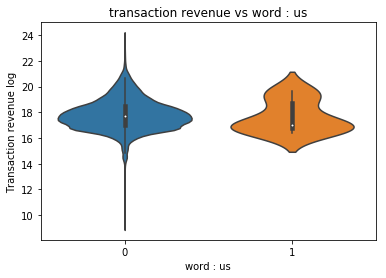

word : verizon  : is catagorigal
0    11435
1       80
Name: 77, dtype: int64


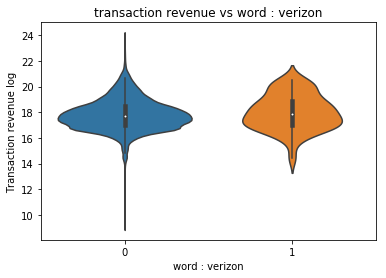

word : wayport  : is catagorigal
0    11503
1       12
Name: 78, dtype: int64


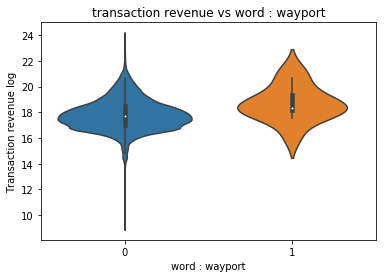

word : yahoo  : is catagorigal
0    11499
1       16
Name: 79, dtype: int64


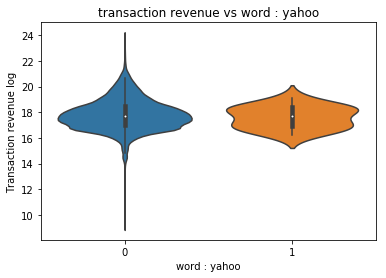

word : youtube  : is catagorigal
0    11504
1       11
Name: 80, dtype: int64


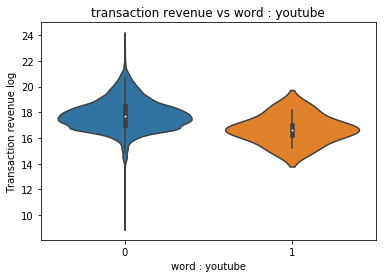

word : ztomy  : is catagorigal
0    11502
1       13
Name: 81, dtype: int64


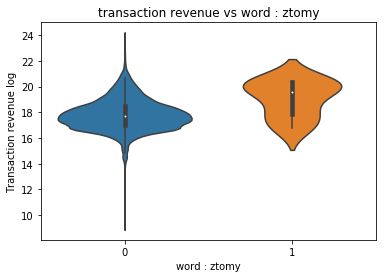

index  : is numerical
count     11515.000000
mean     451512.228485
std      262552.480618
min         752.000000
25%      224373.000000
50%      455213.000000
75%      674860.000000
max      903317.000000
Name: index, dtype: float64


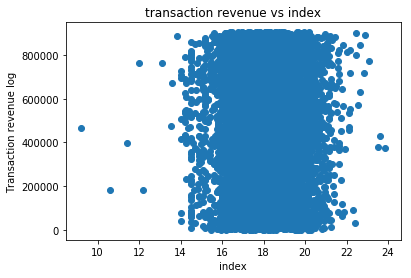

channelGrouping  : is catagorigal
Referral          5311
Organic Search    3438
Direct            2042
Paid Search        468
Display            142
Social             104
Affiliates           9
(Other)              1
Name: channelGrouping, dtype: int64


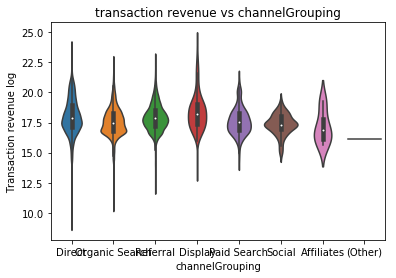

date  : is catagorigal
Monday       2054
Tuesday      2020
Wednesday    1931
Thursday     1902
Friday       1879
Sunday        947
Saturday      782
Name: date, dtype: int64


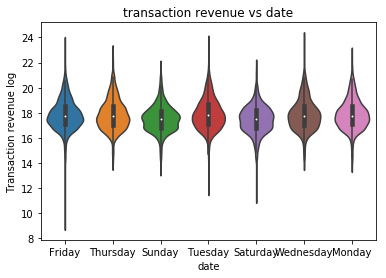

visitNumber  : is catagorigal
1      4465
2      2511
3      1431
4       878
5       555
6       356
7       246
8       175
9       149
10      131
11       76
12       73
14       50
13       47
16       35
15       29
17       25
18       20
21       18
22       17
24       17
20       17
19       15
26       12
23       12
25       10
31       10
28        9
29        8
30        6
       ... 
43        1
45        1
305       1
246       1
69        1
61        1
72        1
106       1
293       1
78        1
102       1
315       1
91        1
295       1
92        1
84        1
96        1
46        1
108       1
74        1
299       1
63        1
48        1
245       1
41        1
53        1
130       1
40        1
75        1
99        1
Name: visitNumber, Length: 109, dtype: int64


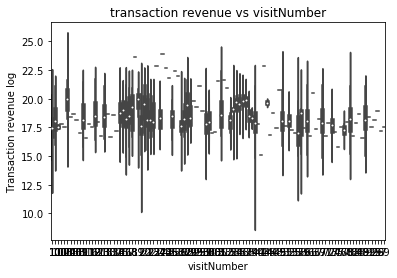

visitStartTime  : is catagorigal
Afternoon    11515
Name: visitStartTime, dtype: int64


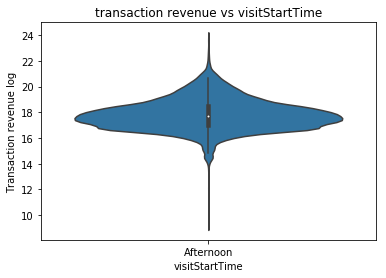

browser  : is catagorigal
Chrome               10353
Safari                 780
Firefox                191
Internet Explorer      109
Edge                    58
Safari (in-app)         12
Android Webview          6
Opera                    5
Amazon Silk              1
Name: browser, dtype: int64


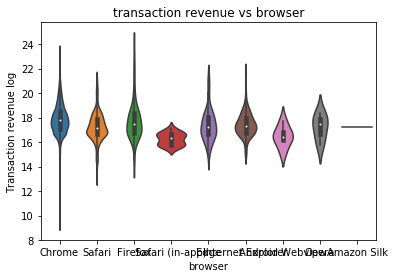

deviceCategory  : is catagorigal
desktop    10495
mobile       852
tablet       168
Name: deviceCategory, dtype: int64


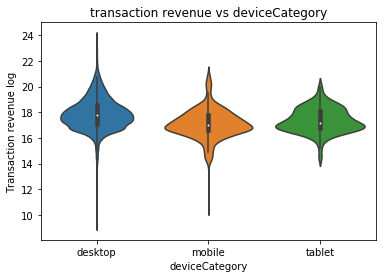

isMobile  : is catagorigal
False    10495
True      1020
Name: isMobile, dtype: int64


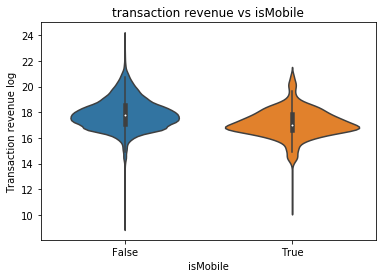

operatingSystem  : is catagorigal
Macintosh        6426
Windows          2309
Chrome OS         994
Linux             782
iOS               536
Android           467
Windows Phone       1
Name: operatingSystem, dtype: int64


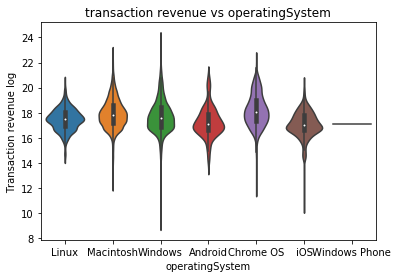

medium  : is catagorigal
referral     5415
organic      3438
(none)       2042
cpc           468
cpm           142
affiliate       9
(not set)       1
Name: medium, dtype: int64


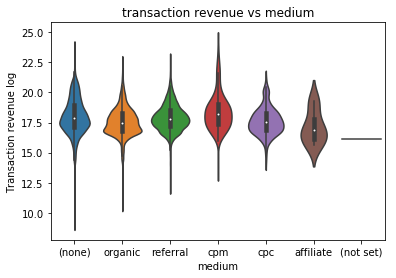

city  : is catagorigal
not available in demo dataset    4579
New York                         1506
Mountain View                    1209
San Francisco                     729
Sunnyvale                         455
Chicago                           422
Los Angeles                       289
Seattle                           228
Austin                            210
San Jose                          202
Ann Arbor                         193
Cambridge                         119
San Bruno                         103
Kirkland                          101
Atlanta                            98
Washington                         98
Santa Clara                        80
Toronto                            64
Salem                              57
Houston                            56
Irvine                             53
(not set)                          49
Palo Alto                          48
Pittsburgh                         39
San Diego                          38
Maracaibo                  

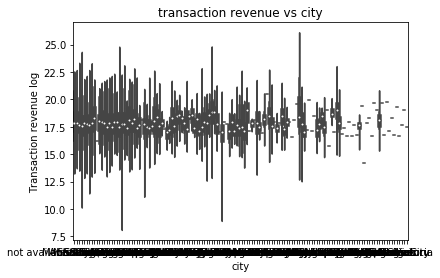

continent  : is catagorigal
Americas     11283
Asia           125
Europe          79
Oceania         14
Africa           8
(not set)        6
Name: continent, dtype: int64


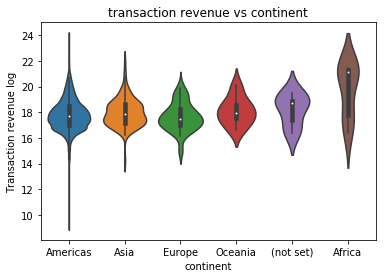

country  : is catagorigal
United States     10953
Canada              190
Venezuela            63
Mexico               20
Taiwan               19
Japan                17
United Kingdom       16
Australia            13
Puerto Rico          11
Indonesia            11
Brazil               10
Singapore            10
India                10
Hong Kong             9
Switzerland           9
Colombia              8
South Korea           8
Germany               8
Ireland               6
(not set)             6
China                 6
Israel                6
Chile                 5
Thailand              5
Belgium               5
Argentina             5
France                5
Russia                4
Ecuador               4
Ukraine               4
                  ...  
Peru                  2
Italy                 2
Finland               2
Turkey                2
Spain                 2
Kuwait                2
Sweden                2
Georgia               2
South Africa          2
St. Lucia     

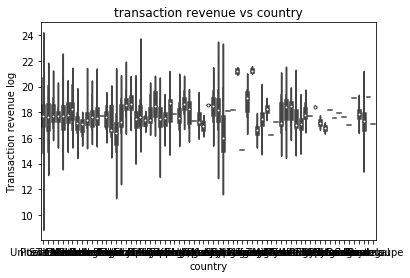

metro  : is catagorigal
not available in demo dataset         4579
San Francisco-Oakland-San Jose CA     2919
New York NY                           1518
Chicago IL                             423
Los Angeles CA                         343
Seattle-Tacoma WA                      336
(not set)                              269
Austin TX                              210
Detroit MI                             194
Boston MA-Manchester NH                136
Atlanta GA                              99
Washington DC (Hagerstown MD)           98
Roanoke-Lynchburg VA                    57
Houston TX                              56
Denver CO                               40
San Diego CA                            39
Pittsburgh PA                           39
Dallas-Ft. Worth TX                     26
Phoenix AZ                              14
Portland OR                             13
Charlotte NC                            13
Philadelphia PA                         11
London                        

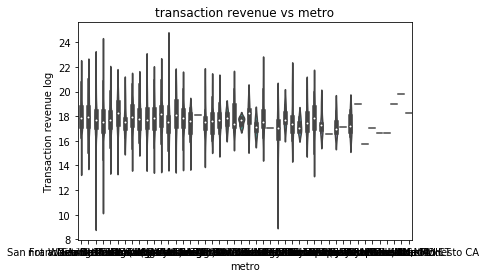

region  : is catagorigal
not available in demo dataset    4579
California                       3305
New York                         1507
Illinois                          423
Washington                        336
Texas                             303
Michigan                          194
Massachusetts                     137
Georgia                            99
District of Columbia               98
Ontario                            68
Virginia                           57
Pennsylvania                       50
(not set)                          46
Colorado                           40
Zulia                              36
Arizona                            14
North Carolina                     14
Oregon                             13
New Jersey                         12
England                            11
Tennessee                          11
Quebec                             11
Florida                             9
Jakarta                             7
State of Sao Paulo       

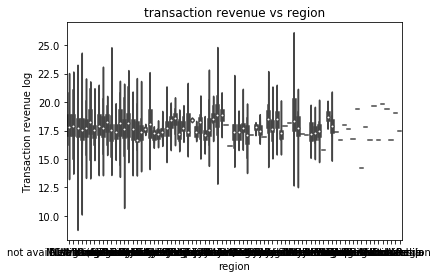

subContinent  : is catagorigal
Northern America    11143
South America          98
Eastern Asia           59
Southeast Asia         32
Western Europe         30
Northern Europe        27
Central America        26
Western Asia           21
Caribbean              16
Eastern Europe         14
Australasia            14
Southern Asia          11
Southern Europe         8
(not set)               6
Eastern Africa          3
Southern Africa         2
Central Asia            2
Western Africa          2
Northern Africa         1
Name: subContinent, dtype: int64


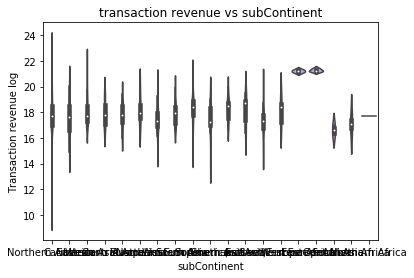

hits  : is numerical
count     11515
unique      215
top          18
freq        375
Name: hits, dtype: object


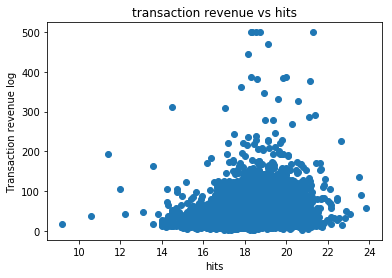

pageviews  : is numerical
count     11515
unique      168
top          16
freq        478
Name: pageviews, dtype: object


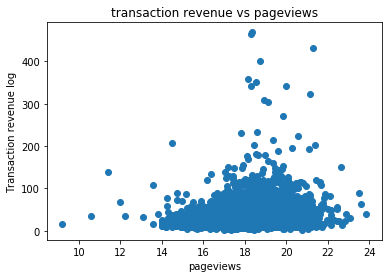

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

colnames=processing_data_train.columns

for v in colnames:
  #for countvectorizer print word name  
  if str(v).isdigit():
        txt='word : '+findkey(v)
  else:
        txt=v
  if (v=='transactionRevenue' or v=='logtransactionRevenue' ):
     continue
      
  if (processing_data_train[v].value_counts().shape[0]>150):
    print(txt, ' : is numerical')
    print(processing_data_train[v].describe())
    processing_data_train[v]=processing_data_train[v].astype('int')
    plt.scatter(processing_data_train['logtransactionRevenue'], processing_data_train[v])
    plt.ylabel("Transaction revenue log")
    plt.xlabel(txt)
    plt.title("transaction revenue vs "+str(txt))

  else:
    
    print(txt,' : is catagorigal')
    #convert from object type
    processing_data_train[v]=processing_data_train[v].astype('str')
    print(processing_data_train[v].value_counts())
    sns.violinplot(x=v,y='logtransactionRevenue',data=processing_data_train)
    plt.ylabel("Transaction revenue log")
    plt.xlabel(txt)
    plt.title("transaction revenue vs " +str(txt))

  plt.show()

From the above plot it seems for visit starttime='Afternoon' all data are present so we will remove that
transactionRevenue is removed and while merging with countvect index is also added so removed that

## Featurization part 2
### city country metro region are having a lot of catagory has a lot of catagory so replace those by mean revenue

In [68]:
#city country metro region are having a lot of catagory
#Countrywise total revenue
processing_data_train['transactionRevenue']=processing_data_train['transactionRevenue'].astype('float')
a=processing_data_train.groupby('country')['transactionRevenue'].agg(['mean','count'])
print("\ncountrywise statistics")
print(a.sort_values(by='mean',ascending=False))
print(a.sort_values(by='count',ascending=False))
a=processing_data_train.groupby('city')['transactionRevenue'].agg(['mean','count'])
print("**"*50)
print("\ncity statistics")
print(a.sort_values(by='mean',ascending=False))
print(a.sort_values(by='count',ascending=False))
a=processing_data_train.groupby('metro')['transactionRevenue'].agg(['mean','count'])
print("**"*50)
print("\nmetro statistics")
print(a.sort_values(by='mean',ascending=False))
print(a.sort_values(by='count',ascending=False))
a=processing_data_train.groupby('region')['transactionRevenue'].agg(['mean','count'])
print("**"*50)
print("\nregion statistics")
print(a.sort_values(by='mean',ascending=False))
print(a.sort_values(by='count',ascending=False))


countrywise statistics
                              mean  count
country                                  
Kenya                 1.756233e+09      3
Nigeria               1.651200e+09      2
Japan                 3.958229e+08     17
Portugal              2.158000e+08      1
Venezuela             2.123000e+08     63
Curaçao               2.063300e+08      1
Belgium               1.984100e+08      5
Spain                 1.923950e+08      2
Canada                1.727607e+08    190
Ecuador               1.687325e+08      4
Indonesia             1.673073e+08     11
Hong Kong             1.631067e+08      9
Malaysia              1.572833e+08      3
Australia             1.342508e+08     13
United States         1.326067e+08  10953
(not set)             1.282967e+08      6
United Arab Emirates  1.233533e+08      3
Kuwait                1.191100e+08      2
Ukraine               1.168800e+08      4
Puerto Rico           1.093491e+08     11
United Kingdom        1.055906e+08     16
Israel    

Kenya Nigeria japan has highest no of mean revenue. USA,CANADA,Venezuela,Mexico has highest no of total transaction  

Minato,Fort Collins has highest no of mean revenue. New York,Mountain View,San Francisco has highest no of total transaction  

Milwaukee WI,Roanoke-Lynchburg VA has highest no of mean revenue. San Francisco-Oakland-San Jose CA,New York NY,Chicago IL has highest no of total transaction  

Tokyo ,Alberta has highest no of mean revenue. Iowa,Istanbul has highest no of total transaction  

So lets replace city,country,metro,region with there avg logrevenue amount

In [69]:
processing_data_train['logtransactionRevenue']=processing_data_train['logtransactionRevenue'].astype('int')
country_mean=processing_data_train.groupby('country')['logtransactionRevenue'].agg(['mean'])
city_mean=processing_data_train.groupby('city')['logtransactionRevenue'].agg(['mean'])
metro_mean=processing_data_train.groupby('metro')['logtransactionRevenue'].agg(['mean'])
region_mean=processing_data_train.groupby('region')['logtransactionRevenue'].agg(['mean'])

In [70]:
print('before changing country with mean',processing_data_train['country'].tail(5))
processing_data_train['country']=processing_data_train['country'].apply(lambda x: country_mean.loc[str(x)])
print('after changing country with mean',processing_data_train['country'].tail(5))
processing_data_train['city']=processing_data_train['city'].apply(lambda x: city_mean.loc[str(x)])
processing_data_train['metro']=processing_data_train['metro'].apply(lambda x: metro_mean.loc[str(x)])
processing_data_train['region']=processing_data_train['region'].apply(lambda x: region_mean.loc[str(x)])

before changing country with mean 11510    United States
11511    United States
11512      South Korea
11513    United States
11514    United States
Name: country, dtype: object
after changing country with mean 11510    17.315347
11511    17.315347
11512    17.375000
11513    17.315347
11514    17.315347
Name: country, dtype: float64


In [71]:
#we can access mean value for a country by a.loc['Anguilla']

In [72]:
processing_data_train=processing_data_train.drop(['visitStartTime','transactionRevenue','index'],axis=1)

## Featurization part 3

'channelGrouping','date','browser','deviceCategory','isMobile','operatingSystem','medium','city','continent','country','metro','region','subContinent' are catagorigal need numeric representation

city country metro region are having a lot of catagory

In [73]:
processing_data_train.iloc[0:5,80:100]
l=['channelGrouping','date','browser','deviceCategory','isMobile','operatingSystem','medium','city','continent','country','metro','region','subContinent' ]
for i in l:
    print("\n\n\n\n******************\n",i,"\n")
    print(processing_data_train[i].value_counts())





******************
 channelGrouping 

Referral          5311
Organic Search    3438
Direct            2042
Paid Search        468
Display            142
Social             104
Affiliates           9
(Other)              1
Name: channelGrouping, dtype: int64




******************
 date 

Monday       2054
Tuesday      2020
Wednesday    1931
Thursday     1902
Friday       1879
Sunday        947
Saturday      782
Name: date, dtype: int64




******************
 browser 

Chrome               10353
Safari                 780
Firefox                191
Internet Explorer      109
Edge                    58
Safari (in-app)         12
Android Webview          6
Opera                    5
Amazon Silk              1
Name: browser, dtype: int64




******************
 deviceCategory 

desktop    10495
mobile       852
tablet       168
Name: deviceCategory, dtype: int64




******************
 isMobile 

False    10495
True      1020
Name: isMobile, dtype: int64




******************
 operat

In [74]:
processing_data_train.city.unique
print(processing_data_train.columns)

Index([                      0,                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10,                      11,
                            12,                      13,
                            14,                      15,
                            16,                      17,
                            18,                      19,
                            20,                      21,
                            22,                      23,
                            24,                      25,
                            26,                      27,
                            28,                      29,
                            30,                      31,
                            32,                      33,
                            34,

### Make onehot for the catagorigal variables

In [75]:
#convert to onehot for channelGrouping  all are in l isMobile is boolean
l=['channelGrouping','date','browser','deviceCategory','operatingSystem','medium','continent','subContinent']
print(processing_data_train.columns)
#cannot drop special char like () in column name but by replaceing columnname are converting to nan for 0,1,2,3..

for i in l:
  print("create onehot for ",i)  
  onehot=pd.get_dummies(processing_data_train[i])
  processing_data_train=processing_data_train.drop(i,axis=1)
  processing_data_train=processing_data_train.join(onehot)
  #remove column if its ['(none)','not available in demo dataset'] 
  processing_data_train=processing_data_train[processing_data_train.columns.drop(list(processing_data_train.filter(regex='not available')))]
  processing_data_train=processing_data_train[processing_data_train.columns.drop(list(processing_data_train.filter(regex='not set')))]
  processing_data_train=processing_data_train[processing_data_train.columns.drop(list(processing_data_train.filter(regex='none')))]
    
processing_data_train.info()
print(processing_data_train.columns)

Index([                      0,                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10,                      11,
                            12,                      13,
                            14,                      15,
                            16,                      17,
                            18,                      19,
                            20,                      21,
                            22,                      23,
                            24,                      25,
                            26,                      27,
                            28,                      29,
                            30,                      31,
                            32,                      33,
                            34,

In [76]:
processing_data_train.columns

Index([                 0,                  1,                  2,
                        3,                  4,                  5,
                        6,                  7,                  8,
                        9,
       ...
       'Northern America',  'Northern Europe',    'South America',
         'Southeast Asia',  'Southern Africa',    'Southern Asia',
        'Southern Europe',   'Western Africa',     'Western Asia',
         'Western Europe'],
      dtype='object', length=153)

#### convert bolean value to 1/0

In [77]:
processing_data_train[processing_data_train['isMobile']==0]

,0,1,2,3,4,5,6,7,8,9,...,Northern America,Northern Europe,South America,Southeast Asia,Southern Africa,Southern Asia,Southern Europe,Western Africa,Western Asia,Western Europe
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [83]:
# Take a copy of DF in different memory
temp=processing_data_train.copy() #deep=True)
print(id(processing_data_train))
print(id(temp))
print(type(temp)) #,temp.sample(2))

2284203289736
2284232562392
<class 'pandas.core.frame.DataFrame'>


In [84]:
#processing_data_train['isMobile']=processing_data_train['isMobile'].astype(int)
processing_data_train['isMobile']=processing_data_train['isMobile'].apply(lambda x:1 if x is True else 0)
train_columns=processing_data_train.drop('logtransactionRevenue',axis=1).columns
train_columns

Index([                 0,                  1,                  2,
                        3,                  4,                  5,
                        6,                  7,                  8,
                        9,
       ...
       'Northern America',  'Northern Europe',    'South America',
         'Southeast Asia',  'Southern Africa',    'Southern Asia',
        'Southern Europe',   'Western Africa',     'Western Asia',
         'Western Europe'],
      dtype='object', length=152)

In [85]:
processing_data_train['isMobile'][0:13]

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     1
9     0
10    0
11    0
12    0
Name: isMobile, dtype: int64

### So now all variables are converted to numeric and god to apply model

In [86]:
processing_data_train.to_csv('processing_data_train.csv')

In [87]:
train_columns=processing_data_train.drop('logtransactionRevenue',axis=1).columns
X_train=processing_data_train.drop('logtransactionRevenue',axis=1).values
y_train=processing_data_train['logtransactionRevenue'].values
print('training shape',X_train.shape,y_train.shape)

training shape (11515, 152) (11515,)


# Create model 
#### With CV=5 and hyperparameter

In [88]:
import warnings 
warnings.filterwarnings('ignore') 
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.grid_search import GridSearchCV 

#Linear
fit_intercept=[True,False]
normalize=[True,False]
tuned_parameters=dict(fit_intercept=fit_intercept,normalize=normalize)
from sklearn.model_selection import validation_curve
#Using GridSearchCV
#model = GridSearchCV(LinearRegression(n_jobs=-1), tuned_parameters, cv=5) 
#model.fit(X_train, y_train) 
#print('Best parameters \n',model.best_estimator_) #print('Model test score', model.score(X_test, y_test))
#optimumfit_intercept=model.best_estimator_.fit_intercept
#optimumnormalize=model.best_estimator_.normalize 
#model = LinearRegression(normalize=optimumnormalize,fit_intercept=optimumfit_intercept) 


#Using ridge
alpha=[.1,1,5,10,15,20]
normalize=[True,False]
solver=['auto']
tuned_parameters=dict(fit_intercept=fit_intercept,normalize=normalize,alpha=alpha,solver=solver)
#Using GridSearchCV
model = GridSearchCV(Ridge(), tuned_parameters, cv=5) 
model.fit(X_train, y_train) 
print('Best parameters \n',model.best_estimator_) #print('Model test score', model.score(X_test, y_test))
optimumfit_intercept=model.best_estimator_.fit_intercept
optimumnormalize=model.best_estimator_.normalize
optimumalpha=model.best_estimator_.alpha
optimumsolver=model.best_estimator_.solver
model = Ridge(normalize=optimumnormalize,fit_intercept=optimumfit_intercept) 

model.fit(X_train, y_train) #confusion matrix pred2 = model.predict(X_test) mat=pd.crosstab(y_test, pred2, rownames=['Actual'], colnames=['Predicted'], margins=True print('confusion matrix\n',mat) aa=pd.DataFrame({'type':['Grid search BOW'],'train_score':[model.score(X_train,y_train)], #print(aa)
model.score(X_train, y_train, sample_weight=None)

Best parameters 
 Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


0.19741077102067262

In [102]:
#print(model.coef_)
coefs = np.abs(model.coef_) 
print(coefs)
indices = np.argsort(coefs)  #[::-1] 
indices
print(list(zip(model.coef_, train_columns)))

[0.35397463 0.1590252  0.13291408 0.14077854 0.04662521 1.0660199
 0.34149676 0.35876357 0.13528262 0.04156058 0.14455344 0.36628911
 0.57122717 0.05239904 0.19880215 0.04131687 0.23430523 0.27513061
 0.38095836 0.06727123 0.03920938 0.373147   0.48998066 0.54678443
 0.19107211 1.17949621 0.21214951 0.47507513 0.0431008  0.14802946
 0.10610284 0.17793288 0.03260971 0.03869847 0.0510972  0.36918478
 0.03562901 0.10749154 0.1827263  0.18975979 0.28710111 0.402992
 0.07804634 0.14712638 0.14884472 0.12063107 0.34477132 0.25883904
 0.82184722 0.15132255 0.01785097 0.33075469 0.4472556  0.83882235
 0.0911208  0.15082229 0.08857131 0.10986409 0.20374033 0.48600223
 0.90303129 0.02739839 0.16517165 0.13887875 0.00439282 0.19854633
 0.02437827 0.49305184 0.02969852 0.06917435 0.0095176  0.2211209
 0.2117533  0.00439282 0.13578429 0.13375659 0.12037628 0.03904369
 0.77249395 0.08030116 0.39285631 0.90665804 0.01564844 1.15596027
 0.7676868  0.61497005 0.05428966 0.1385469  0.02532655 0.0221069


# Make prediction

## Preprocess test data same as train

In [114]:
def processtest(bb):
    
  #flatten json file
  print("total shape",bb.shape)
  aa=pd.DataFrame(bb.pop('device').apply(pd.io.json.loads).values.tolist(), index=bb.index)
  bb=bb.join(aa)
  aa=pd.DataFrame(bb.pop('trafficSource').apply(pd.io.json.loads).values.tolist(), index=bb.index)
  bb=bb.join(aa)
  aa=pd.DataFrame(bb.pop('geoNetwork').apply(pd.io.json.loads).values.tolist(), index=bb.index)
  bb=bb.join(aa)
  aa=pd.DataFrame(bb.pop('totals').apply(pd.io.json.loads).values.tolist(), index=bb.index)
  bb=bb.join(aa)
  aa=bb['adwordsClickInfo'].apply(lambda x: pd.Series(x))
  bb=bb.join(aa)
  bb=bb.drop('adwordsClickInfo',axis=1)
  bb['date']=  \
  bb['date'].apply(lambda x: calendar.day_name[datetime.date(int(str(x)[:4]),int(str(x)[4:6]),int(str(x)[6:8])).weekday()])

  #merging source text and networkDomain text into source column    
  bb['source']= bb["source"].map(str) + bb["networkDomain"]
  #use as per train
  final_counts = count_vect.transform(bb['source'].values)
  bb=bb.reset_index()
  bb=pd.DataFrame(final_counts.todense()).join(bb)

  #some test data maybe new
  def findmean(feature,x):
      try:  
        y=feature.loc[str(x)]  
      except:
        y=0
      return int(y)  
        
  #replace country,city,region,continent by mean
  bb['country']=bb['country'].apply(lambda x: findmean(country_mean,x)) #city_mean.loc[str(x)])
  bb['city']=bb['city'].apply(lambda x: findmean(city_mean,x))
  bb['metro']=bb['metro'].apply(lambda x: findmean(metro_mean,x))
  bb['region']=bb['region'].apply(lambda x: findmean(region_mean,x))

  #onehot
  l=['channelGrouping','date','browser','deviceCategory','operatingSystem','medium','continent','subContinent' ]

  #onehot code
  for i in l:
    print("create onehot for ",i)  
    onehot=pd.get_dummies(bb[i])
    bb=bb.drop(i,axis=1)
    bb=bb.join(onehot)
    bb=bb[bb.columns.drop(list(bb.filter(regex='not available')))]
    bb=bb[bb.columns.drop(list(bb.filter(regex='not set')))]
    bb=bb[bb.columns.drop(list(bb.filter(regex='none')))]
    #drop Blackberry if operatingSystem='BlackBerry' because that will be onehotcoded in deviceCategory
    if i=='operatingSystem':
       bb=bb[bb.columns.drop(list(bb.filter(regex='BlackBerry')))]
       print("dropping blackberry as operating system")
        
  
    #if (i=='deviceCategory' or i=='operatingSystem'):
    #   print('check for BlackBerry') 
    #   print(bb[bb.deviceCategory=='BlackBerry']['deviceCategory'].value_counts())
    #   print(bb[bb.operatingSystem=='BlackBerry']['operatingSystem'].value_counts())
    
    
  #convert boolean to int
  print(bb['isMobile'][0:3])
  bb['isMobile']=bb['isMobile'].astype(int) #(bb['isMobile'] == 'True').astype(int)


  #now remove the columns which are not in train
  print('text columns',len(bb.columns),bb.columns)
  #fullVisitorId is required for submission  
  visitid=bb['fullVisitorId'].reset_index()
  # Now there could be some features not present in test data so we have to fill some 0 value there
  print("now test columns",len(bb.columns))
  bb = bb.assign(**{col:0 for col in train_columns.difference(bb.columns).tolist()})
  bb=bb[train_columns]
  print("now test columns",len(bb.columns))
  bb=bb.join(visitid)  
  print('text columns',len(bb.columns))
    
  return bb

In [115]:
#raw_data_test['deviceCategory'].value_counts()

In [ ]:
raw_data_test=pd.read_csv("test.csv") #,nrows=20000)
print('raw_data_test shape',raw_data_test.shape)
preprocess_data_test=processtest(raw_data_test)
#blackberry is common in deviceCategory and operatingSystem itseems

raw_data_test shape (804684, 12)
total shape (804684, 12)


### Predict from test data

In [ ]:
len(model.coef_)
#fillna with 0
X_test=preprocess_data_test.drop(['index','fullVisitorId'],axis=1)
for i in X_test.columns:
  X_test[i].fillna(0, inplace=True)

#np.isnan(openingPriceTrain).any()

X_test=X_test.values
output=model.predict(X_test)
output=pd.DataFrame(output)
#preprocess_data_test.reset_index().join(pd.DataFrame(output).reset_index())
output.columns=['PredictedLogRevenue']
output=preprocess_data_test.join(output)[['fullVisitorId','PredictedLogRevenue']]
output.to_csv("outputfile.csv",sep=',',index=False)

In [133]:
#is.na(preprocess_data_test.drop(['index','fullVisitorId'],axis=1))